### Prerequisite Packages

In [1]:
import sys
import os
import pandas as pd
import numpy as np
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import DataLoader, Dataset, WeightedRandomSampler
from torcheval.metrics import BinaryAccuracy, BinaryPrecision, BinaryRecall, BinaryF1Score
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import confusion_matrix

In [2]:
sys.path.append('../')

from modules.cross_attentionb import CrossAttentionB
from modules.dataloader import load_npy_files
from modules.classifier import DenseLayer, BCELoss, CustomLoss, BCEWithLogits
from modules.linear_transformation import LinearTransformations

### Data Loading

In [3]:
class MultimodalDataset(Dataset):
    def __init__(self, id_label_df, text_features, audio_features, video_features):
        self.id_label_df = id_label_df
        
        # Convert feature lists to dictionaries for fast lookup
        self.text_features = {os.path.basename(file).split('.')[0]: tensor for file, tensor in text_features}
        self.audio_features = {os.path.basename(file).split('_')[1].split('.')[0]: tensor for file, tensor in audio_features}
        self.video_features = {os.path.basename(file).split('_')[0]: tensor for file, tensor in video_features}

        # List to store missing files
        self.missing_files = []

        # Filter out entries with missing files
        self.valid_files = self._filter_valid_files()

    def _filter_valid_files(self):
        valid_indices = []
        missing_files = []

        for idx in range(len(self.id_label_df)):
            imdbid = self.id_label_df.iloc[idx]['IMDBid']

            # Check if the IMDBid exists in each modality's features
            if imdbid in self.text_features and imdbid in self.audio_features and imdbid in self.video_features:
                valid_indices.append(idx)
            else:
                missing_files.append({'IMDBid': imdbid})

        # Filter id_label_df to only include valid rows
        self.id_label_df = self.id_label_df.iloc[valid_indices].reset_index(drop=True)
        self.missing_files = missing_files
        
        # Update valid_indices to reflect the new indices after resetting
        valid_indices = list(range(len(self.id_label_df)))

        # Return valid indices
        return valid_indices

    def __len__(self):
        return len(self.valid_files)

    def __getitem__(self, idx):
        # Get the original index from the filtered valid files
        original_idx = self.valid_files[idx]
        imdbid = self.id_label_df.iloc[original_idx]['IMDBid']
        label = self.id_label_df.iloc[original_idx]['Label']

        # Retrieve data from the loaded features
        text_data = self.text_features.get(imdbid, torch.zeros((1024,)))
        audio_data = self.audio_features.get(imdbid, torch.zeros((1, 197, 768)))
        video_data = self.video_features.get(imdbid, torch.zeros((95, 768)))
        
        # Define label mapping
        label_map = {'red': 1, 'green': 0} 
        
        # Convert labels to tensor using label_map
        try:
            label_data = torch.tensor([label_map[label]], dtype=torch.float32)
        except KeyError as e:
            print(f"Error: Label '{e}' not found in label_map.")
            raise

        return imdbid, text_data, audio_data, video_data, label_data


In [4]:
def collate_fn(batch):
    # Unpack batch elements
    imdbids, text_data, audio_data, video_data, label_data = zip(*batch)

    # Convert lists to tensors
    text_data = torch.stack(text_data)
    audio_data = torch.stack(audio_data)

    # Padding for video data
    # Determine maximum length of video sequences in the batch
    video_lengths = [v.size(0) for v in video_data]
    max_length = max(video_lengths)

    # Pad video sequences to the maximum length
    video_data_padded = torch.stack([
        F.pad(v, (0, 0, 0, max_length - v.size(0)), "constant", 0)
        for v in video_data
    ])

    # Convert labels to tensor and ensure the shape [batch_size, 1]
    label_data = torch.stack(label_data)  # Convert list of tensors to a single tensor

    return imdbids, text_data, audio_data, video_data_padded, label_data


In [5]:
# Load the labels DataFrame
id_label_df = pd.read_excel('../misc/MM-Trailer_dataset.xlsx')

# Define the directories
text_features_dir = '../misc/text_features'
audio_features_dir = '../misc/audio_features'
video_features_dir = '../misc/video_features'

# Load the feature vectors from each directory
text_features = load_npy_files(text_features_dir)
audio_features = load_npy_files(audio_features_dir)
video_features = load_npy_files(video_features_dir)

print(f"Number of text feature vectors loaded: {len(text_features)}")
print(f"Number of audio feature vectors loaded: {len(audio_features)}")
print(f"Number of video feature vectors loaded: {len(video_features)}")

# Drop unnecessary columns
id_label_df = id_label_df.drop(columns=['Movie Title', 'URL'])

full_dataset = MultimodalDataset(id_label_df, text_features, audio_features, video_features)

# perform train-test split on the filtered DataFrame
train_df, val_test_df = train_test_split(
    full_dataset.id_label_df, test_size=0.3, random_state=42, stratify=full_dataset.id_label_df['Label'])

# Further splitting remaining set into validation and test sets
val_df, test_df = train_test_split(
    val_test_df, test_size=0.5, random_state=42, stratify=val_test_df['Label'])

print("train_df shape:", train_df.shape)
print("val_df shape:", val_df.shape)
print("test_df shape:", test_df.shape)

print("Train label distribution:", train_df['Label'].value_counts())
print("Validation label distribution:", val_df['Label'].value_counts())
print("Test label distribution:", test_df['Label'].value_counts())

print("-" * 40)

# create datasets based on these splits
train_dataset = MultimodalDataset(train_df, text_features, audio_features, video_features)
val_dataset = MultimodalDataset(val_df, text_features, audio_features, video_features)
test_dataset = MultimodalDataset(test_df, text_features, audio_features, video_features)

# Create DataLoaders
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=0, collate_fn=collate_fn)
val_dataloader = DataLoader(val_dataset, batch_size=16, shuffle=True, num_workers=0, collate_fn=collate_fn)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=0, collate_fn=collate_fn)


# Function to calculate and print the size of each DataLoader
def print_dataloader_sizes(dataloader, name):
    total_samples = len(dataloader.dataset)  # Get the size of the dataset
    num_batches = len(dataloader)  # Get the number of batches
    print(f"{name} DataLoader: Total Samples = {total_samples}, Number of Batches = {num_batches}")

# Print sizes of each DataLoader
print_dataloader_sizes(train_dataloader, "Train")
print_dataloader_sizes(val_dataloader, "Validation")
print_dataloader_sizes(test_dataloader, "Test")



Number of text feature vectors loaded: 1353
Number of audio feature vectors loaded: 1353
Number of video feature vectors loaded: 1353
train_df shape: (947, 2)
val_df shape: (203, 2)
test_df shape: (203, 2)
Train label distribution: Label
green    707
red      240
Name: count, dtype: int64
Validation label distribution: Label
green    151
red       52
Name: count, dtype: int64
Test label distribution: Label
green    152
red       51
Name: count, dtype: int64
----------------------------------------
Train DataLoader: Total Samples = 947, Number of Batches = 60
Validation DataLoader: Total Samples = 203, Number of Batches = 13
Test DataLoader: Total Samples = 203, Number of Batches = 13


### Important Functions

In [6]:
# Cross Attention Function
def PairCrossAttention(modalityAlpha, modalityBeta, d_out_kq=768, d_out_v=768):
    cross_attn = CrossAttentionB(modalityAlpha.shape[-1], modalityBeta.shape[-1], d_out_kq, d_out_v)
    modalityAlphaBeta = cross_attn(modalityAlpha, modalityBeta)
    return modalityAlphaBeta

In [7]:
class MultiheadCrossAttention(nn.Module):
    def __init__(self, embed_dim, num_heads=8):
        super().__init__()
        self.multihead_attn = nn.MultiheadAttention(embed_dim, num_heads, batch_first=True)
        
    def forward(self, query, key_value):
        # Ensure inputs are 3D: (batch_size, sequence_length, embed_dim)
        if query.dim() == 2:
            query = query.unsqueeze(1)  # Add sequence length dimension
        if key_value.dim() == 2:
            key_value = key_value.unsqueeze(1)  # Add sequence length dimension
            
        output, _ = self.multihead_attn(query, key_value, key_value)
        return output

### Hyperparameters and Important Assignments

In [ ]:
# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

# !!! Choose if pytorch's multiheadattention or own crossattention
isMultiHead = True 

# Modality assignments
modality_assignments = {
    'modalityAlpha': 'audio_features',
    'modalityBeta': 'text_features',
    'modalityGamma': 'video_features'
}

# Define the loss function
isBCELoss = True                          # !!! SET ACCORDINGLY !!!
criterion = BCELoss()
# criterion = BCEWithLogits()
# criterion = CustomLoss(pos_weight=2.94)  

# Hyperparameters
threshold = 0.5        # for predictions
learning_rate = 1e-5
dropout_rate = 0.4    # for FinalClassifier
num_epochs = 10       # Set the number of epochs you want to train for

num_folds = 5         # Set the number of folds for cross-validation
batch_size = 32      # Set the batch size for cross-validation

# !!! Choose Classifier !!! False = Dense Layer, True = Final Classifier
isFinalClassifier = True

Device: cuda


### SMCA Functions and Model

In [9]:
def SMCAStage1(modalityAlpha, modalityBeta, d_out_kq, d_out_v, device):
    
    if isMultiHead: 
        cross_attn = MultiheadCrossAttention(d_out_v).to(device)
    else:
        cross_attn = CrossAttentionB(modalityAlpha.shape[-1], modalityBeta.shape[-1], d_out_kq, d_out_v).to(device)

    # Cross-attention: Alpha -> Beta
    alphaBeta = cross_attn(modalityAlpha, modalityBeta)  # Shape: (batch_size, num_queries, d_out_v)

    # Cross-attention: Beta -> Alpha
    betaAlpha = cross_attn(modalityBeta, modalityAlpha)  # Shape: (batch_size, num_kv, d_out_v)

    # Get the sequence lengths
    seq_len_alpha = alphaBeta.size(1)  # This is num_queries
    seq_len_beta = betaAlpha.size(1)    # This is num_kv

    # Instead of expanding, use padding or trimming
    max_seq_len = max(seq_len_alpha, seq_len_beta)

    # Ensure both alphaBeta and betaAlpha are of shape (batch_size, max_seq_len, d_out_v)
    if seq_len_alpha < max_seq_len:
        alphaBeta = torch.nn.functional.pad(alphaBeta, (0, 0, 0, max_seq_len - seq_len_alpha), value=0)

    if seq_len_beta < max_seq_len:
        betaAlpha = torch.nn.functional.pad(betaAlpha, (0, 0, 0, max_seq_len - seq_len_beta), value=0)

    # Concatenate cross-attention outputs along the feature dimension (-1)
    modalityAlphaBeta = torch.cat((alphaBeta, betaAlpha), dim=-1)  # Shape: (batch_size, max_seq_len, 2 * d_out_v)

    return modalityAlphaBeta


In [10]:
class ProjectionLayer(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(ProjectionLayer, self).__init__()
        self.linear = nn.Linear(input_dim, output_dim)

    def forward(self, x):
        return self.linear(x)

In [11]:
def SMCAStage2(modalityAlphaBeta, modalityGamma, d_out_kq, d_out_v, device):
    # modalityAlphaBeta: (batch_size, seq_len, 2 * d_out_v) [output of Stage 1]
    
    # Initialize the projection layer for modalityAlphaBeta
    projection_layer = ProjectionLayer(modalityAlphaBeta.shape[-1], d_out_v).to(device)

    # Project modalityAlphaBeta to (batch_size, seq_len, d_out_v)
    modalityAlphaBetaProjected = projection_layer(modalityAlphaBeta)

    # Initialize the cross-attention module
    if isMultiHead: 
        cross_attn = MultiheadCrossAttention(d_out_v).to(device)
    else:
        cross_attn = CrossAttentionB(modalityAlphaBetaProjected.shape[-1], modalityGamma.shape[-1], d_out_kq, d_out_v).to(device)

    # Cross-attention: AlphaBeta -> Gamma
    alphaBetaGamma = cross_attn(modalityAlphaBetaProjected, modalityGamma)  # Shape: (batch_size, seq_len_alphaBeta, d_out_v)

    # Cross-attention: Gamma -> AlphaBeta
    gammaAlphaBeta = cross_attn(modalityGamma, modalityAlphaBetaProjected)  # Shape: (batch_size, seq_len_gamma, d_out_v)

    # Get the sequence lengths for both modalities
    seq_len_alphaBeta = alphaBetaGamma.size(1)
    seq_len_gamma = gammaAlphaBeta.size(1)

    # Pad the smaller sequence to match the larger one (expanding to before)
    max_seq_len = max(seq_len_alphaBeta, seq_len_gamma)

    if seq_len_alphaBeta < max_seq_len:
        alphaBetaGamma = torch.nn.functional.pad(alphaBetaGamma, (0, 0, 0, max_seq_len - seq_len_alphaBeta), value=0)

    if seq_len_gamma < max_seq_len:
        gammaAlphaBeta = torch.nn.functional.pad(gammaAlphaBeta, (0, 0, 0, max_seq_len - seq_len_gamma), value=0)

    # Concatenate along the feature dimension (-1)
    multimodal_representation = torch.cat((alphaBetaGamma, gammaAlphaBeta), dim=-1)  # Shape: (batch_size, max(seq_len_alphaBeta, seq_len_gamma), 2 * d_out_v)

    # Apply Global Average Pooling across the feature (sequence to before)
    GAP = torch.mean(multimodal_representation, dim=1)  # Shape: (batch_size, 2 * d_out_v)

    return GAP

In [12]:
class SMCAModel(nn.Module):
    def __init__(self, d_out_kq, d_out_v, device):
        super(SMCAModel, self).__init__()
        self.d_out_kq = d_out_kq
        self.d_out_v = d_out_v
        self.device = device
    
    def forward(self, modalityAlpha, modalityBeta, modalityGamma):
        # Stage 1: Cross attention between modalityAlpha and modalityBeta
        modalityAlphaBeta = SMCAStage1(modalityAlpha, modalityBeta, self.d_out_kq, self.d_out_v, self.device)

        # Stage 2: Cross attention with modalityAlphaBeta (as query) and modalityGamma (as key-value)
        multimodal_representation = SMCAStage2(modalityAlphaBeta, modalityGamma, self.d_out_kq, self.d_out_v, self.device)

        return multimodal_representation

In [13]:

def train_model(
    model, 
    dense_layer, 
    dataloader, 
    criterion, 
    optimizer, 
    device,
    output_dir='results/', 
    output_filename='train_predictions.csv'
):
    model.train()
    dense_layer.train()
    total_loss = 0.0
    
    # Create the output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)

    # Initialize metrics for binary classification
    precision_metric = BinaryPrecision().to(device)
    recall_metric = BinaryRecall().to(device)
    f1_metric = BinaryF1Score().to(device)
    accuracy_metric = BinaryAccuracy().to(device) 
    
    # Reset metrics at the start of training
    precision_metric.reset()
    recall_metric.reset()
    f1_metric.reset()
    accuracy_metric.reset()
    
    # List to collect results for CSV
    results = []
    
    print("-" * 20, "Train", "-" * 20)

    for imdbids, text_features, audio_features, video_features, targets in dataloader:
        text_features, audio_features, video_features, targets = (
            text_features.to(device),
            audio_features.to(device),
            video_features.to(device),
            targets.to(device).view(-1)
        )
                
        # Squeeze the audio features to remove the extra dimension
        audio_features = audio_features.squeeze(1).to(device) 

        # Apply linear transformations to match dimensions
        linear_transform_text = LinearTransformations(text_features.shape[-1], 768).to(device)   

        # Transform features to match the target dimension
        text_features = linear_transform_text(text_features).to(device)    
        
        transformed_features = {
            'audio_features': audio_features,
            'text_features': text_features,
            'video_features': video_features
        }

        outputs = model(
            modalityAlpha=transformed_features[modality_assignments['modalityAlpha']].to(device),  # Use the dictionary for modality assignment
            modalityBeta=transformed_features[modality_assignments['modalityBeta']].to(device),
            modalityGamma=transformed_features[modality_assignments['modalityGamma']].to(device)
        )

        # Pass the fused features through the dense layer
        predictions = dense_layer(outputs).view(-1)

        # Compute loss
        loss = criterion(predictions, targets)
        total_loss += loss.item()
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # !!!Apply if BCEWithLogits or CustomLoss!!!
        if not isBCELoss:
            predictions = torch.sigmoid(predictions)

        # Apply threshold to get binary predictions
        preds = (predictions >= threshold).float()
        
        # # Print model predictions and targets for each batch
        # print("-" * 15, "Training", "-" * 15)
        # print(f"Movie Trailer IDs:\n {imdbids}")
        # print(f"Predictions (raw):  {np.round(predictions.detach().cpu().numpy(), 3)}")            
        # print(f"Binary Predictions: {preds.detach().cpu().numpy()}")
        # print(f"Targets:            {targets.detach().cpu().numpy()}")
        
        # Collect results for each sample
        for i in range(len(imdbids)):
            results.append({
                'IMDBid': imdbids[i],
                'Raw Prediction': predictions[i].item(),
                'Binary Prediction': preds[i].item(),
                'Target': targets[i].item()
            })
        
        # Update metrics for binary classification
        precision_metric.update(preds.long(), targets.long())
        recall_metric.update(preds.long(), targets.long())
        f1_metric.update(preds.long(), targets.long())
        accuracy_metric.update(preds.long(), targets.long()) 

    # Compute average precision, recall, F1 score, and accuracy
    precision = precision_metric.compute().item()
    recall = recall_metric.compute().item()
    f1_score = f1_metric.compute().item()
    accuracy = accuracy_metric.compute().item()  # Compute accuracy
    
    train_average_loss = total_loss / len(dataloader)

    print(f"Train Accuracy: {accuracy:.4f}")
    print(f"Train Precision: {precision:.4f}")
    print(f"Train Recall: {recall:.4f}")
    print(f"Train F1 Score: {f1_score:.4f}")
    print(f"Train Loss: {train_average_loss:.4f}")
    
    # Create DataFrame and save to CSV
    results_df = pd.DataFrame(results)
    output_filepath = os.path.join(output_dir, output_filename)
    results_df.to_csv(output_filepath, index=False, header=True)

    return train_average_loss, accuracy, precision, recall, f1_score

In [14]:
def evaluate_model(
    model, 
    dense_layer, 
    dataloader, 
    criterion, 
    device,
    output_dir='results/', 
    output_filename='eval_predictions.csv'
):
    model.eval()
    dense_layer.eval()
    total_loss = 0.0
    
    # Create the output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)

    # Initialize metrics for binary classification
    precision_metric = BinaryPrecision().to(device)
    recall_metric = BinaryRecall().to(device)
    f1_metric = BinaryF1Score().to(device)
    accuracy_metric = BinaryAccuracy().to(device) 
    
    # Reset metrics at the start of training
    precision_metric.reset()
    recall_metric.reset()
    f1_metric.reset()
    accuracy_metric.reset()
    
    all_predictions = []
    all_targets = []
    
    # List to collect results for CSV
    results = []
    
    print("-" * 20, "Eval", "-" * 20)
    
    with torch.no_grad():
         for imdbids, text_features, audio_features, video_features, targets in dataloader:
            text_features, audio_features, video_features, targets = (
                text_features.to(device),
                audio_features.to(device),
                video_features.to(device),
                targets.to(device).view(-1)
            )
        
            # Squeeze the audio features to remove the extra dimension
            audio_features = audio_features.squeeze(1).to(device) 

            # Apply linear transformations to match dimensions
            linear_transform_text = LinearTransformations(text_features.shape[-1], 768).to(device)   

            # Transform features to match the target dimension
            text_features = linear_transform_text(text_features).to(device)    
            
            transformed_features = {
                'audio_features': audio_features,
                'text_features': text_features,
                'video_features': video_features
            }

            outputs = model(
                modalityAlpha=transformed_features[modality_assignments['modalityAlpha']].to(device),  # Use the dictionary for modality assignment
                modalityBeta=transformed_features[modality_assignments['modalityBeta']].to(device),
                modalityGamma=transformed_features[modality_assignments['modalityGamma']].to(device)
            )

            # Pass the fused features through the dense layer
            predictions = dense_layer(outputs).view(-1)

            # Compute loss
            loss = criterion(predictions, targets)
            total_loss += loss.item()

            # !!!Apply if BCEWithLogits or CustomLoss!!!
            if not isBCELoss:
                predictions = torch.sigmoid(predictions)

            # Apply threshold to get binary predictions
            preds = (predictions >= threshold).float()
            
            all_predictions.extend(predictions.cpu().numpy())
            all_targets.extend(targets.cpu().numpy())
            
            # # Print model predictions and targets for each batch
            # print("-" * 15, "Eval", "-" * 15)
            # print(f"Movie Trailer IDs:\n {imdbids}")
            # print(f"Predictions (raw):  {np.round(predictions.cpu().numpy(), 3)}")            
            # print(f"Binary Predictions: {preds.cpu().numpy()}")
            # print(f"Targets:            {targets.cpu().numpy()}")
            
            # Collect results for each sample
            for i in range(len(imdbids)):
                results.append({
                    'IMDBid': imdbids[i],
                    'Raw Prediction': predictions[i].item(),
                    'Binary Prediction': preds[i].item(),
                    'Target': targets[i].item()
                })
            
            # Update metrics for binary classification
            precision_metric.update(preds.long(), targets.long())
            recall_metric.update(preds.long(), targets.long())
            f1_metric.update(preds.long(), targets.long())
            accuracy_metric.update(preds.long(), targets.long()) 
            
    # Compute average precision, recall, F1 score, and accuracy
    precision = precision_metric.compute().item()
    recall = recall_metric.compute().item()
    f1_score = f1_metric.compute().item()
    accuracy = accuracy_metric.compute().item() 
    
    # Calculate confusion matrix
    eval_conf_matrix = confusion_matrix(all_targets, np.round(all_predictions))

    eval_average_loss = total_loss / len(dataloader)
    print(f"Eval Accuracy: {accuracy:.4f}")
    print(f"Eval Precision: {precision:.4f}")
    print(f"Eval Recall: {recall:.4f}")
    print(f"Eval F1 Score: {f1_score:.4f}")
    print(f"Eval Loss: {eval_average_loss:.4f}")
    
    # Create DataFrame and save to CSV
    results_df = pd.DataFrame(results)
    output_filepath = os.path.join(output_dir, output_filename)
    results_df.to_csv(output_filepath, index=False, header=True)
    
    return eval_average_loss, accuracy, precision, recall, f1_score, eval_conf_matrix

In [15]:

def test_model(
    model, 
    dense_layer, 
    dataloader, 
    criterion, 
    device,
    output_dir='results/', 
    output_filename='test_predictions.csv'
):
    model.eval()
    dense_layer.eval()
    total_loss = 0

    # Create the output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)

    # Initialize metrics for binary classification
    precision_metric = BinaryPrecision().to(device)
    recall_metric = BinaryRecall().to(device)
    f1_metric = BinaryF1Score().to(device)
    accuracy_metric = BinaryAccuracy().to(device) 

    all_predictions = []
    all_targets = []
    
    # List to collect results for CSV
    results = []
    
    print("-" * 20, "Test", "-" * 20)

    with torch.no_grad():
        for imdbids, text_features, audio_features, video_features, targets in dataloader:
            text_features, audio_features, video_features, targets = (
                text_features.to(device),
                audio_features.to(device),
                video_features.to(device),
                targets.to(device).view(-1)
            )
            
            # Squeeze the audio features to remove the extra dimension
            audio_features = audio_features.squeeze(1).to(device) 

            # Apply linear transformations to match dimensions
            linear_transform_text = LinearTransformations(text_features.shape[-1], 768).to(device)   

            # Transform features to match the target dimension
            text_features = linear_transform_text(text_features).to(device)    
            
            transformed_features = {
                'audio_features': audio_features,
                'text_features': text_features,
                'video_features': video_features
            }

            outputs = model(
                modalityAlpha=transformed_features[modality_assignments['modalityAlpha']].to(device),  # Use the dictionary for modality assignment
                modalityBeta=transformed_features[modality_assignments['modalityBeta']].to(device),
                modalityGamma=transformed_features[modality_assignments['modalityGamma']].to(device)
            )

            # Pass the fused features through the dense layer
            predictions = dense_layer(outputs).view(-1)
                
            # Compute loss
            loss = criterion(predictions, targets)
            total_loss += loss.item()

            # !!!Apply if BCEWithLogits or CustomLoss!!!
            if not isBCELoss:
                predictions = torch.sigmoid(predictions)

            # Apply threshold to get binary predictions
            preds = (predictions >= threshold).float()
            
            # Collect predictions and targets for the confusion matrix
            all_predictions.extend(preds.cpu().numpy())
            all_targets.extend(targets.cpu().numpy())

            # # Print model predictions and targets for each batch
            # print("-" * 15, "Test", "-" * 15)
            # print(f"Movie Trailer IDs: {imdbids}")
            # print(f"Predictions (raw):  {np.round(predictions.cpu().numpy(), 3)}")            
            # print(f"Binary Predictions: {preds.cpu().numpy()}")
            # print(f"Targets:            {targets.cpu().numpy()}")
            
            # Collect results for each sample
            for i in range(len(imdbids)):
                results.append({
                    'IMDBid': imdbids[i],
                    'Raw Prediction': predictions[i].item(),
                    'Binary Prediction': preds[i].item(),
                    'Target': targets[i].item()
                })
            
            # Update metrics for binary classification
            precision_metric.update(preds.long(), targets.long())
            recall_metric.update(preds.long(), targets.long())
            f1_metric.update(preds.long(), targets.long())
            accuracy_metric.update(preds.long(), targets.long()) 

    # Compute average precision, recall, F1 score, and accuracy
    precision = precision_metric.compute().item()
    recall = recall_metric.compute().item()
    f1_score = f1_metric.compute().item()
    accuracy = accuracy_metric.compute().item()
    
    # Generate confusion matrix
    test_conf_matrix = confusion_matrix(all_targets, all_predictions)

    test_average_loss = total_loss / len(dataloader)
    print(f"Test Accuracy: {accuracy:.4f}")
    print(f"Test Precision: {precision:.4f}")
    print(f"Test Recall: {recall:.4f}")
    print(f"Test F1 Score: {f1_score:.4f}")
    print(f"Test Loss: {test_average_loss:.4f}")
    
    # Create DataFrame and save to CSV
    results_df = pd.DataFrame(results)
    output_filepath = os.path.join(output_dir, output_filename)
    results_df.to_csv(output_filepath, index=False, header=True)

    return test_average_loss, accuracy, precision, recall, f1_score, test_conf_matrix


In [16]:
def get_optimizer(parameters, lr=learning_rate):
    # Create an optimizer, for example, Adam
    return optim.Adam(parameters, lr=lr)

In [17]:
class FinalClassifier(nn.Module):
    def __init__(self, input_size, dropout_rate=dropout_rate):
        super(FinalClassifier, self).__init__()
        self.fc1 = nn.Linear(input_size, 512)  # First fully connected layer
        self.bn1 = nn.BatchNorm1d(512)          # Batch normalization after first layer
        self.fc2 = nn.Linear(512, 256)          # Second fully connected layer
        self.bn2 = nn.BatchNorm1d(256)          # Batch normalization after second layer
        self.fc3 = nn.Linear(256, 128)          # Third fully connected layer
        self.bn3 = nn.BatchNorm1d(128)          # Batch normalization after third layer
        self.fc4 = nn.Linear(128, 64)          # Second fully connected layer
        self.bn4 = nn.BatchNorm1d(64)          # Batch normalization after third layer

        self.dropout = nn.Dropout(dropout_rate) # Dropout layer
        self.dense = nn.Linear(64, 1)          # Final dense layer for binary classification
        self.relu = nn.ReLU()                    # ReLU activation
        self.sigmoid = nn.Sigmoid()              # Sigmoid activation for final output

    def forward(self, x):
        x = self.fc1(x)                         # First fully connected layer
        x = self.bn1(x)                         # Apply batch normalization
        x = self.relu(x)                        # Apply ReLU activation

        x = self.fc2(x)                         # second fully connected layer
        x = self.bn2(x)                         # Apply batch normalization
        x = self.relu(x)                        # Apply ReLU activation
        x = self.dropout(x)                     # Apply dropout
        
        x = self.fc3(x)                         # third fully connected layer
        x = self.bn3(x)                         # Apply batch normalization
        x = self.relu(x)                        # Apply ReLU activation

        x = self.fc4(x)                         # fourth fully connected layer
        x = self.bn4(x)                         # Apply batch normalization
        x = self.relu(x)                        # Apply ReLU activation
        x = self.dropout(x)                     # Apply dropout
        
        x = self.dense(x)                       # Final dense layer
        if isBCELoss:
            x = self.sigmoid(x)                  # Apply sigmoid activation
        return x                                 # Output probabilities for BCELoss


In [18]:
def plot_confusion_matrix(conf_matrix, class_names=['Negative', 'Positive']):
    plt.figure(figsize=(6, 5))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False,
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

In [19]:
# Function to plot training and validation loss
def plot_losses(train_losses, val_losses):
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Training Loss', color='blue', marker='o')
    plt.plot(val_losses, label='Validation Loss', color='orange', marker='x')
    plt.title('Training and Validation Loss over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()
    plt.show()

----------------------------------------
Epoch 1/10
-------------------- Train --------------------
Train Accuracy: 0.6262
Train Precision: 0.2756
Train Recall: 0.2917
Train F1 Score: 0.2834
Train Loss: 0.6502
-------------------- Eval --------------------
Eval Accuracy: 0.6552
Eval Precision: 0.2188
Eval Recall: 0.1346
Eval F1 Score: 0.1667
Eval Loss: 0.6640
Training Loss: 0.6502, Validation Loss: 0.6640
----------------------------------------
Epoch 2/10
-------------------- Train --------------------
Train Accuracy: 0.6103
Train Precision: 0.2451
Train Recall: 0.2583
Train F1 Score: 0.2515
Train Loss: 0.6585
-------------------- Eval --------------------
Eval Accuracy: 0.6798
Eval Precision: 0.1579
Eval Recall: 0.0577
Eval F1 Score: 0.0845
Eval Loss: 0.6241
Training Loss: 0.6585, Validation Loss: 0.6241
----------------------------------------
Epoch 3/10
-------------------- Train --------------------
Train Accuracy: 0.6262
Train Precision: 0.2702
Train Recall: 0.2792
Train F1 Score

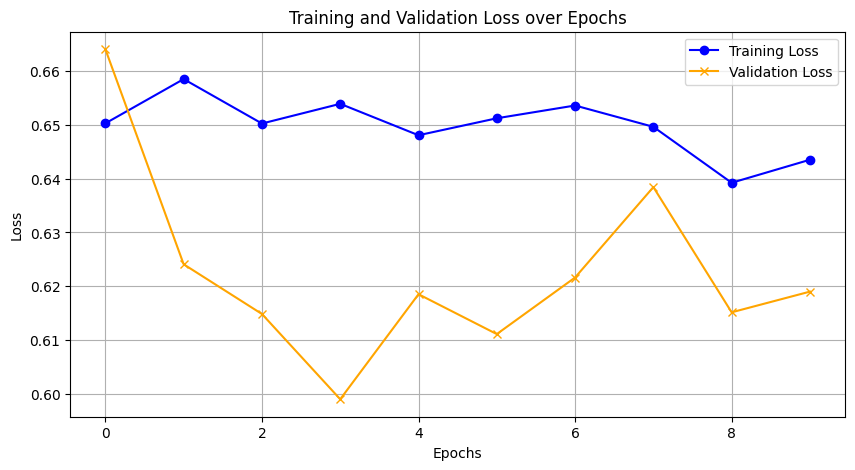

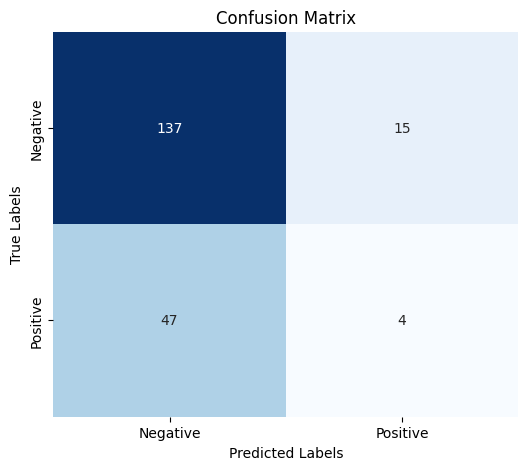

In [20]:
if __name__ == "__main__":
    torch.manual_seed(42)

    # Initialize the SMCA model A
    model = SMCAModel(768, 768, device).to(device)  # Dimension for d_out_kq and d_out_v

    # Determine the output dimensions
    output_dim = 768

    # Own DenseLayer or FinalClassifier
    if isFinalClassifier:
        dense_layer = FinalClassifier(output_dim*2).to(device) 
    else:
        dense_layer = DenseLayer(output_dim*2).to(device)

    optimizer = get_optimizer(list(model.parameters()) + list(dense_layer.parameters()), learning_rate)

    # Lists to store the training and validation losses
    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        print("-" * 40)
        print(f"Epoch {epoch + 1}/{num_epochs}")

        # Ensure you have a dataloader that yields inputs and targets
        train_average_loss, accuracy, precision, recall, f1_score = train_model(model=model, dense_layer=dense_layer, dataloader=train_dataloader, criterion=criterion, optimizer=optimizer, device=device)
        train_losses.append(train_average_loss)  # Store training loss
        
        for name, param in model.named_parameters():
            if param.grad is None:
                print("After train: model:", "No gradient for:", name)
        
        for name, param in dense_layer.named_parameters():
            if param.grad is None:
                print("After train: classifier:", "No gradient for:", name)

        # Validate step
        eval_average_loss, accuracy, precision, recall, f1_score, eval_conf_matrix = evaluate_model(model=model, dense_layer=dense_layer, dataloader=val_dataloader, criterion=criterion, device=device)
        val_losses.append(eval_average_loss)  # Store validation loss
        
        print(f"Training Loss: {train_average_loss:.4f}, Validation Loss: {eval_average_loss:.4f}")

    # Testing the model
    print("-" * 40)
    print("Testing the model on the test set...")
    test_average_loss, accuracy, precision, recall, f1_score, test_conf_matrix = test_model(model=model, dense_layer=dense_layer, dataloader=test_dataloader, criterion=criterion, device=device)
    print("Confusion Matrix:", test_conf_matrix)
    

    plot_losses(train_losses, val_losses)
    plot_confusion_matrix(test_conf_matrix)

In [21]:
# Read the CSV file into a DataFrame
train_df = pd.read_csv('results/train_predictions.csv')
train_df


,IMDBid,Raw Prediction,Binary Prediction,Target
0,tt3225318,0.334559,0.0,1.0
1,tt1754811,0.229509,0.0,1.0
2,tt0088128,0.527322,1.0,0.0
3,tt0373024,0.346895,0.0,0.0
4,tt0363276,0.355119,0.0,1.0
...,...,...,...,...
942,tt0810922,0.427720,0.0,1.0
943,tt7545566,0.403878,0.0,1.0
944,tt7650514,0.299939,0.0,1.0
945,tt0479143,0.484847,0.0,0.0


In [22]:
# Read the CSV file into a DataFrame
train_df = pd.read_csv('results/train_predictions.csv')
print(train_df.head(), "\n\n")

# Display summary information about the DataFrame
print(train_df.info())

      IMDBid  Raw Prediction  Binary Prediction  Target
0  tt3225318        0.334559                0.0     1.0
1  tt1754811        0.229509                0.0     1.0
2  tt0088128        0.527322                1.0     0.0
3  tt0373024        0.346895                0.0     0.0
4  tt0363276        0.355119                0.0     1.0 


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 947 entries, 0 to 946
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   IMDBid             947 non-null    object 
 1   Raw Prediction     947 non-null    float64
 2   Binary Prediction  947 non-null    float64
 3   Target             947 non-null    float64
dtypes: float64(3), object(1)
memory usage: 29.7+ KB
None


In [23]:
# Read the CSV file into a DataFrame
eval_df = pd.read_csv('results/eval_predictions.csv')
print(eval_df.head(), "\n\n")

# Display summary information about the DataFrame
print(eval_df.info())

      IMDBid  Raw Prediction  Binary Prediction  Target
0  tt0383694        0.276229                0.0     0.0
1  tt0387059        0.319271                0.0     0.0
2  tt3824648        0.304211                0.0     1.0
3  tt1634003        0.302757                0.0     0.0
4  tt1728979        0.322664                0.0     1.0 


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 203 entries, 0 to 202
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   IMDBid             203 non-null    object 
 1   Raw Prediction     203 non-null    float64
 2   Binary Prediction  203 non-null    float64
 3   Target             203 non-null    float64
dtypes: float64(3), object(1)
memory usage: 6.5+ KB
None


In [24]:
# Read the CSV file into a DataFrame
test_df = pd.read_csv('results/test_predictions.csv')
print(test_df.head(), "\n\n")

# Display summary information about the DataFrame
print(test_df.info())


       IMDBid  Raw Prediction  Binary Prediction  Target
0  tt10740584        0.356940                0.0     1.0
1   tt0815245        0.176999                0.0     0.0
2   tt0996979        0.288958                0.0     0.0
3   tt1155056        0.254607                0.0     1.0
4   tt4273562        0.352445                0.0     0.0 


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 203 entries, 0 to 202
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   IMDBid             203 non-null    object 
 1   Raw Prediction     203 non-null    float64
 2   Binary Prediction  203 non-null    float64
 3   Target             203 non-null    float64
dtypes: float64(3), object(1)
memory usage: 6.5+ KB
None


### K-Fold Evaluation

In [25]:
def cross_validate_model(
    dataset, 
    model_class, 
    dense_layer_class, 
    num_folds, 
    num_epochs, 
    batch_size, 
    learning_rate,
    output_file,
    device=None
):
    # Set device configuration
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Device: {device}")
    
    # Ensure the output directory exists
    output_dir = os.path.dirname(output_file)
    if output_dir and not os.path.exists(output_dir):
        os.makedirs(output_dir)  # Creates the directory if it does not exist
    
    # Determine the output dimensions
    output_dim = 768

    # Initialize the KFold splitter
    kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)

    # lists to store metrics for each fold
    fold_losses = []
    fold_accuracies = []
    fold_precisions = []
    fold_recalls = []
    fold_f1_scores = []
    


    # Perform K-Fold Cross-Validation
    for fold, (train_idx, val_idx) in enumerate(kf.split(dataset)):
        print("-" * 60)
        print(f"------------------------- Fold {fold + 1 }/{num_folds} -------------------------")

        # Create data loaders for the train and validation sets
        train_sampler = torch.utils.data.SubsetRandomSampler(train_idx)
        val_sampler = torch.utils.data.SubsetRandomSampler(val_idx)
        
        train_dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, sampler=train_sampler, collate_fn=collate_fn)
        val_dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, sampler=val_sampler, collate_fn=collate_fn)
        
        # Initialize the model, dense layer, criterion, and optimizer for each fold
        model = model_class(output_dim, output_dim, device).to(device)
        
        dense_layer = dense_layer_class(input_size=output_dim*2).to(device)
        criterion = BCELoss()
        optimizer = get_optimizer(list(model.parameters()) + list(dense_layer.parameters()), lr=learning_rate)

        # Training loop for each fold
        for epoch in range(num_epochs):
            print(f"------------------------- Epoch {epoch + 1}/{num_epochs} -------------------------")
            
            # Train and evaluate the model on the training and validation sets
            train_average_loss, train_accuracy, train_precision, train_recall, train_f1_score = train_model(model=model, dense_layer=dense_layer, dataloader=train_dataloader, criterion=criterion, optimizer=optimizer, device=device)
            eval_average_loss, eval_accuracy, eval_precision, eval_recall, eval_f1_score, eval_conf_matrix = evaluate_model(model=model, dense_layer=dense_layer, dataloader=val_dataloader, criterion=criterion, device=device)
            
            print(f"Train Loss: {train_average_loss:.4f}, Validation Loss: {eval_average_loss:.4f}")
            print(f"Validation Accuracy: {eval_accuracy:.4f}, Precision: {eval_precision:.4f}, Recall: {eval_recall:.4f}, F1 Score: {eval_f1_score:.4f}")
        
        # Store the validation metrics for this fold
        print(f"Results for Fold {fold}: Validation Loss = {eval_average_loss:.4f}, Precision = {precision:.4f}, Recall = {recall:.4f}, F1 Score = {f1_score:.4f}")
        fold_losses.append(eval_average_loss)
        fold_accuracies.append(eval_accuracy)
        fold_precisions.append(eval_precision)
        fold_recalls.append(eval_recall)
        fold_f1_scores.append(eval_f1_score)


    # Calculate the average metrics across all folds
    avg_loss = np.mean(fold_losses)
    avg_accuracy = np.mean(fold_accuracies)
    avg_precision = np.mean(fold_precisions)
    avg_recall = np.mean(fold_recalls)
    avg_f1_score = np.mean(fold_f1_scores)

    print("-" * 50)
    print("\nK-Fold Cross-Validation Results:")
    print(f"Average Loss: {avg_loss:.4f}")
    print(f"Average Accuracy: {avg_accuracy:.4f}")
    print(f"Average Precision: {avg_precision:.4f}")
    print(f"Average Recall: {avg_recall:.4f}")
    print(f"Average F1 Score: {avg_f1_score:.4f}")

    # Save F1 scores per fold to a .npy file
    np.save(output_file, np.array(fold_f1_scores))
    print(f"F1 scores per fold saved to {output_file}")
    
    # Testing the model
    print("-" * 40)
    print("Testing the model on the test set...")
    test_average_loss, test_accuracy, test_precision, test_recall, test_f1_score, test_conf_matrix = test_model(model=model, dense_layer=dense_layer, dataloader=test_dataloader, criterion=criterion, device=device)


    return avg_loss, avg_accuracy, avg_precision, avg_recall, avg_f1_score

In [26]:
# DenseLayer or FinalClassifier
if isFinalClassifier:
    dense_layer_class = FinalClassifier
else:
    dense_layer_class = DenseLayer

# Run k-fold cross-validation   
results = cross_validate_model(
    dataset=full_dataset,
    model_class=SMCAModel,
    dense_layer_class=dense_layer_class,
    num_epochs=num_epochs,    
    num_folds=num_folds,
    batch_size=batch_size,
    learning_rate=learning_rate,
    output_file="results/SMCA-F1_scores.npy"
)

Device: cuda
------------------------------------------------------------
------------------------- Fold 1/5 -------------------------
------------------------- Epoch 1/10 -------------------------
-------------------- Train --------------------
Train Accuracy: 0.4787
Train Precision: 0.2677
Train Recall: 0.5801
Train F1 Score: 0.3663
Train Loss: 0.7348
-------------------- Eval --------------------
Eval Accuracy: 0.2435
Eval Precision: 0.2322
Eval Recall: 1.0000
Eval F1 Score: 0.3769
Eval Loss: 0.7057
Train Loss: 0.7348, Validation Loss: 0.7057
Validation Accuracy: 0.2435, Precision: 0.2322, Recall: 1.0000, F1 Score: 0.3769
------------------------- Epoch 2/10 -------------------------
-------------------- Train --------------------
Train Accuracy: 0.4667
Train Precision: 0.2474
Train Recall: 0.5160
Train F1 Score: 0.3345
Train Loss: 0.7393
-------------------- Eval --------------------
Eval Accuracy: 0.4465
Eval Precision: 0.2556
Eval Recall: 0.7419
Eval F1 Score: 0.3802
Eval Loss: 0